## SENG 474 - Assignment 1
### Chris Wong - V00780634

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.utils import check_random_state  

## Import Adult Data Set

In [2]:
adult_set = pd.read_csv('cleaned_adult.csv', header = 0)

In [3]:
X = adult_set.drop(columns='income')
y = adult_set.income
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Decision Trees

### Varying alpha and comparing splitting criterion

In [4]:
ccp_alpha = 0
training_accuracy = []
test_accuracy = []
ccp_alphas = []
for i in range (51):
    dt = DecisionTreeClassifier(criterion="gini", ccp_alpha=ccp_alpha)
    dt.fit(X_train,y_train)
    training_accuracy.append(dt.score(X_train,y_train))
    test_accuracy.append(dt.score(X_test,y_test))
    ccp_alphas.append(ccp_alpha)
    ccp_alpha += 0.00002

In [5]:
ccp_alpha_entropy = 0
training_accuracy_entropy = []
test_accuracy_entropy = []
ccp_alphas_entropy = []
for i in range (50):
    dt_entropy = DecisionTreeClassifier(criterion="entropy", ccp_alpha=ccp_alpha_entropy)
    dt_entropy.fit(X_train,y_train)
    training_accuracy_entropy.append(dt_entropy.score(X_train,y_train))
    test_accuracy_entropy.append(dt_entropy.score(X_test,y_test))
    ccp_alphas_entropy.append(ccp_alpha_entropy)
    ccp_alpha_entropy += 0.00002

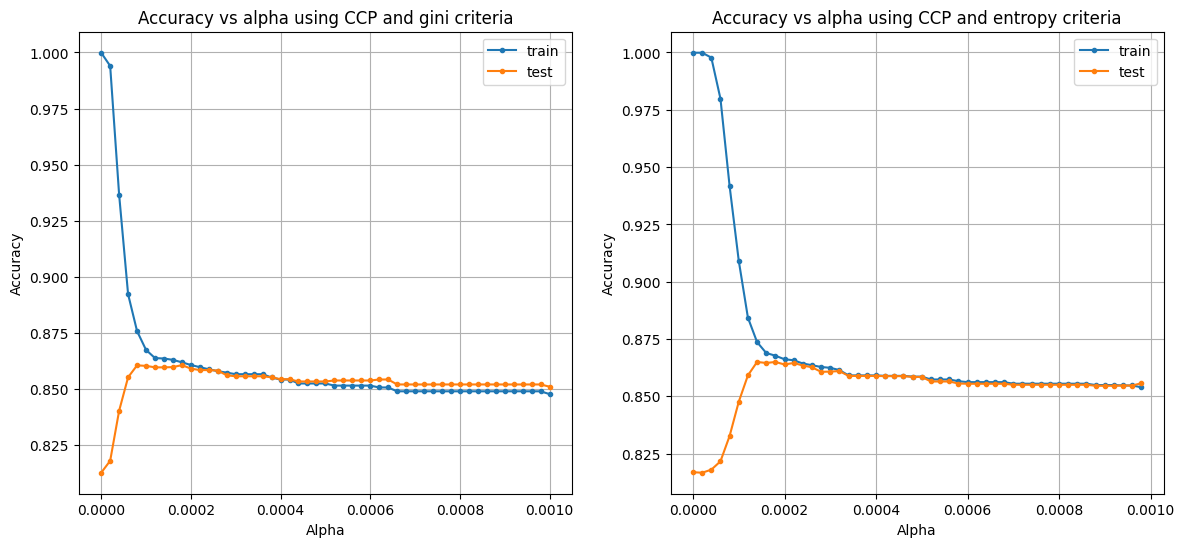

In [6]:
fig, axs = plt.subplots(1,2,figsize=(14,6))
axs[0].set_xlabel("Alpha")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Accuracy vs alpha using CCP and gini criteria")
axs[0].plot(ccp_alphas, training_accuracy, marker=".", label="train")
axs[0].plot(ccp_alphas, test_accuracy, marker=".", label="test")
axs[0].grid('True')
axs[0].legend()

axs[1].set_xlabel("Alpha")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Accuracy vs alpha using CCP and entropy criteria")
axs[1].plot(ccp_alphas_entropy, training_accuracy_entropy, marker=".", label="train")
axs[1].plot(ccp_alphas_entropy, test_accuracy_entropy, marker=".", label="test")
axs[1].grid('True')
axs[1].legend()

### Varying max tree depth

In [7]:
max_depth = 2
training_accuracy_depth = []
test_accuracy_depth = []
depth_list = []
for i in range (39):
    dt_depth = DecisionTreeClassifier(max_depth = max_depth, ccp_alpha=0.0001)
    dt_depth.fit(X_train,y_train)
    training_accuracy_depth.append(dt_depth.score(X_train,y_train))
    test_accuracy_depth.append(dt_depth.score(X_test,y_test))
    depth_list.append(max_depth)
    max_depth += 1

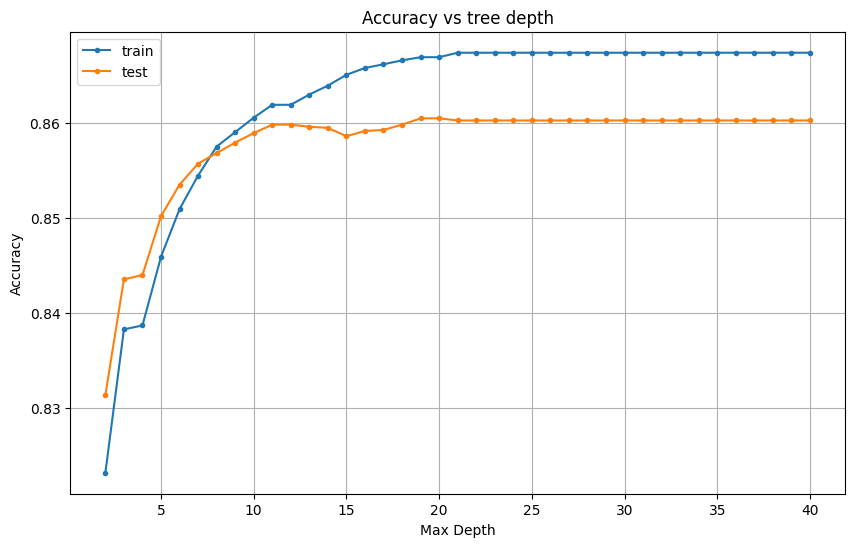

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel("Max Depth")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs tree depth")
ax.plot(depth_list, training_accuracy_depth, marker=".", label="train")
ax.plot(depth_list, test_accuracy_depth, marker=".", label="test")
ax.grid('True')
ax.legend()


## Random Forests

### Change Number of Trees and Out of Bag Error

In [9]:
# Take a subset of the adult set
#-------------------------------
adult_set_rf_trees = adult_set[:5000]
X_rf = adult_set.drop(columns='income')
y_rf = adult_set.income
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=0)
#-------------------------------

trees_training_accuracy = []
trees_test_accuracy = []
tree_list = []
OOB_error_list = []

rf_trees = RandomForestClassifier(n_estimators=10, max_features='sqrt', bootstrap=True, warm_start=True, random_state=0)

#-------------------------------
n_samples = len(X_rf_train)
n_samples_bootstrap = n_samples
#-------------------------------

for i in range (10):
    rf_trees.fit(X_rf_train,y_rf_train)
    
    # Perform the OOB error estimate for the current forest
    #-------------------------------
    unsampled_indices_for_all_trees= []
    for estimator in rf_trees.estimators_:
        random_instance = check_random_state(estimator.random_state)
        sample_indices = random_instance.randint(0, n_samples, n_samples_bootstrap)
        sample_counts = np.bincount(sample_indices, minlength = n_samples)
        unsampled_mask = sample_counts == 0
        indices_range = np.arange(n_samples)
        unsampled_indices = indices_range[unsampled_mask]
        unsampled_indices_for_all_trees += [unsampled_indices]
        
    dictionary = {}
    for tree, unsampled_list in enumerate(unsampled_indices_for_all_trees):
        for sample in unsampled_list:
            prediction = rf_trees.estimators_[tree].predict(X_rf_train.iloc[sample].to_numpy().reshape(1, -1))
            if not dictionary.get(sample):
                dictionary[sample] = [1 if prediction == y_rf_train.iloc[sample] else 0, 1]
            else:
                if prediction == y_train.iloc[sample]:
                    dictionary[sample][0] += 1
                dictionary[sample][1] += 1
    majority_vote_sum = 0
    
    for key, value in dictionary.items():
        majority_vote_sum += 1 if value[0]/value[1] < 0.5 else 0
    OOB_error_percentage = majority_vote_sum/len(dictionary)
    OOB_error_list.append(OOB_error_percentage)
    #-------------------------------
    
    trees_training_accuracy.append(rf_trees.score(X_rf_train,y_rf_train))
    trees_test_accuracy.append(rf_trees.score(X_rf_test,y_rf_test))
    tree_list.append(rf_trees.n_estimators)
    rf_trees.n_estimators += 10    

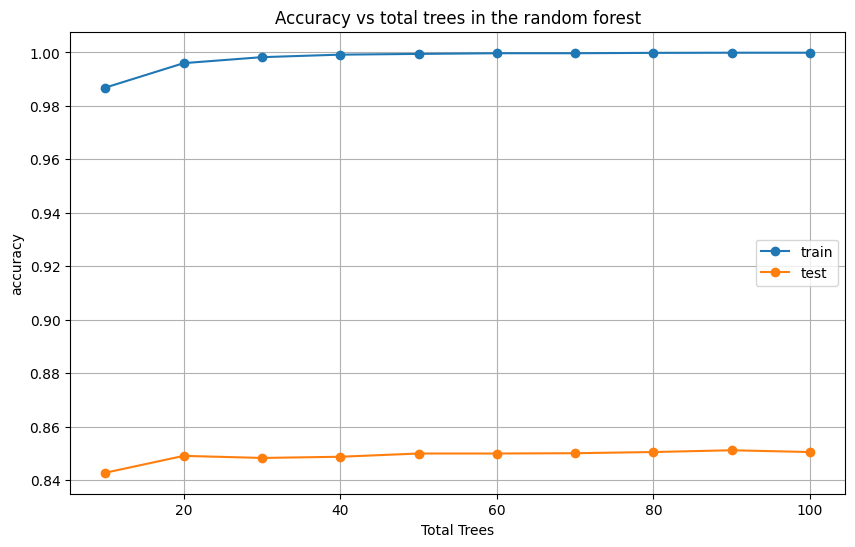

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel("Total Trees")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs total trees in the random forest")
ax.plot(tree_list, trees_training_accuracy, marker="o", label="train")
ax.plot(tree_list, trees_test_accuracy, marker="o", label="test")
ax.legend()
ax.grid('True')
plt.show()

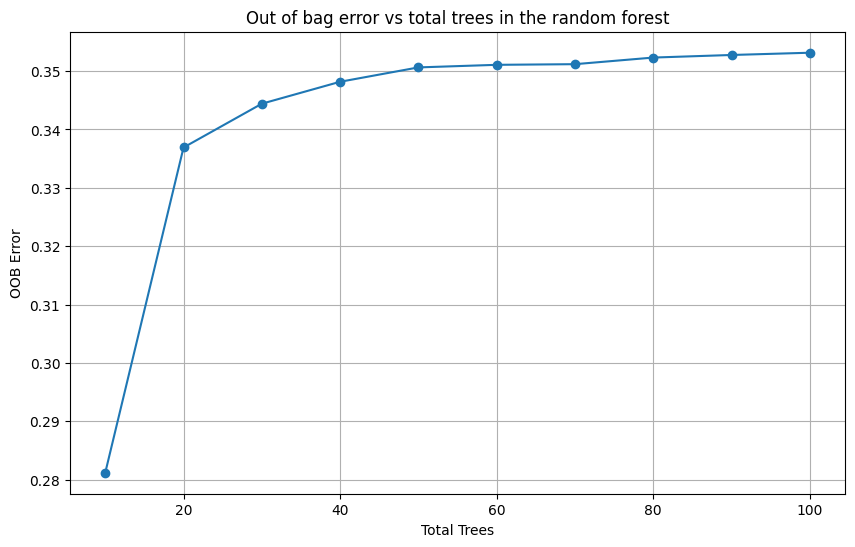

In [11]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel("Total Trees")
ax.set_ylabel("OOB Error")
ax.set_title("Out of bag error vs total trees in the random forest")
ax.plot(tree_list,OOB_error_list, marker="o")
ax.grid('True')
plt.show()

In [12]:
max_samples = 1000
samples_training_accuracy = []
samples_test_accuracy = []
sample_list = []
for i in range (36):
    rf_max_samples = RandomForestClassifier(max_features='sqrt', bootstrap=True, max_samples=max_samples)
    rf_max_samples.fit(X_train,y_train)
    samples_training_accuracy.append(rf_max_samples.score(X_train,y_train))
    samples_test_accuracy.append(rf_max_samples.score(X_test,y_test))
    sample_list.append(max_samples)
    max_samples += 1000

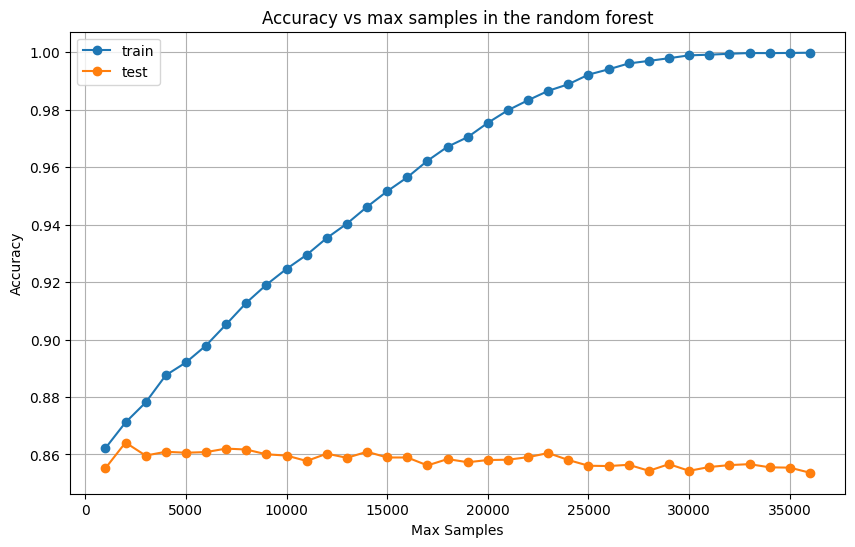

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel("Max Samples")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs max samples in the random forest")
ax.plot(sample_list, samples_training_accuracy, marker="o", label="train")
ax.plot(sample_list, samples_test_accuracy, marker="o", label="test")
ax.legend()
ax.grid('True')
plt.show()

### Change Number of Features

In [14]:
max_features = 1
features_training_accuracy = []
features_test_accuracy = []
features_list = []
for i in range (20):
    rf_max_features = RandomForestClassifier(max_features=max_features, bootstrap=True)
    rf_max_features.fit(X_train,y_train)
    features_training_accuracy.append(rf_max_features.score(X_train,y_train))
    features_test_accuracy.append(rf_max_features.score(X_test,y_test))
    features_list.append(max_features)
    max_features += 5

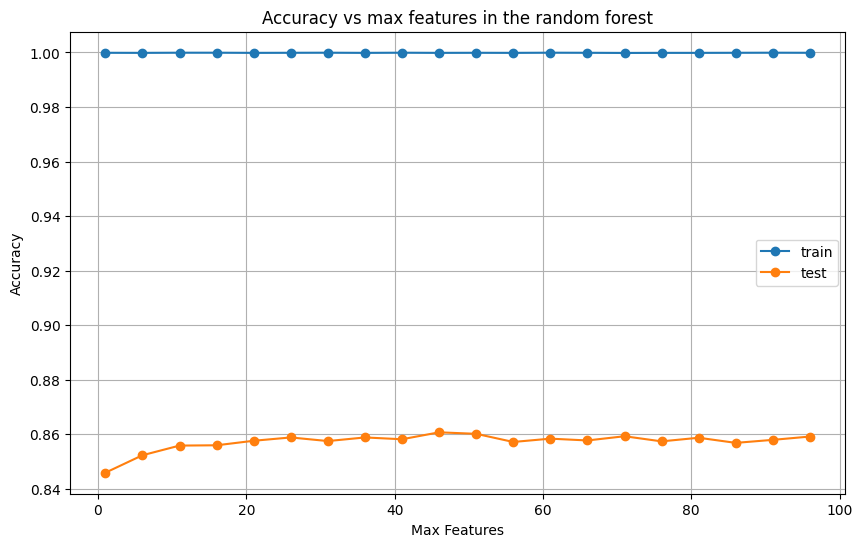

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel("Max Features")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs max features in the random forest")
ax.plot(features_list, features_training_accuracy, marker="o", label="train")
ax.plot(features_list, features_test_accuracy, marker="o", label="test")
ax.legend()
ax.grid('True')
plt.show()

## Neural Networks

### Varying neurons in the hidden layer and comparing SGD and Adam

In [16]:
X_scaled = preprocessing.scale(X)
trainData, testData, trainLabel, testLabel = train_test_split(X_scaled,y,test_size=0.2)

# SGD
neurons_SGD = 3
neurons_list_SGD = []
nn_1_training_accuracy_SGD = []
nn_1_test_accuracy_SGD = []
for i in range(10):
    nn_1 = MLPClassifier(hidden_layer_sizes=(neurons_SGD), max_iter=1000, alpha=1e-4,solver='sgd', learning_rate_init=.001)
    nn_1.fit(trainData,trainLabel)
    nn_1_training_accuracy_SGD.append(nn_1.score(trainData,trainLabel))
    nn_1_test_accuracy_SGD.append(nn_1.score(testData,testLabel))
    neurons_list_SGD.append(neurons_SGD)
    neurons_SGD += 4

# ADAM
neurons_ADAM = 3
neurons_list_ADAM = []
nn_2_training_accuracy_ADAM = []
nn_2_test_accuracy_ADAM = []
for i in range(10):
    nn_2 = MLPClassifier(hidden_layer_sizes=(neurons_SGD), max_iter=1000, alpha=1e-4,solver='adam', learning_rate_init=.001)
    nn_2.fit(trainData,trainLabel)
    nn_2_training_accuracy_ADAM.append(nn_2.score(trainData,trainLabel))
    nn_2_test_accuracy_ADAM.append(nn_2.score(testData,testLabel))
    neurons_list_ADAM.append(neurons_ADAM)
    neurons_ADAM += 4

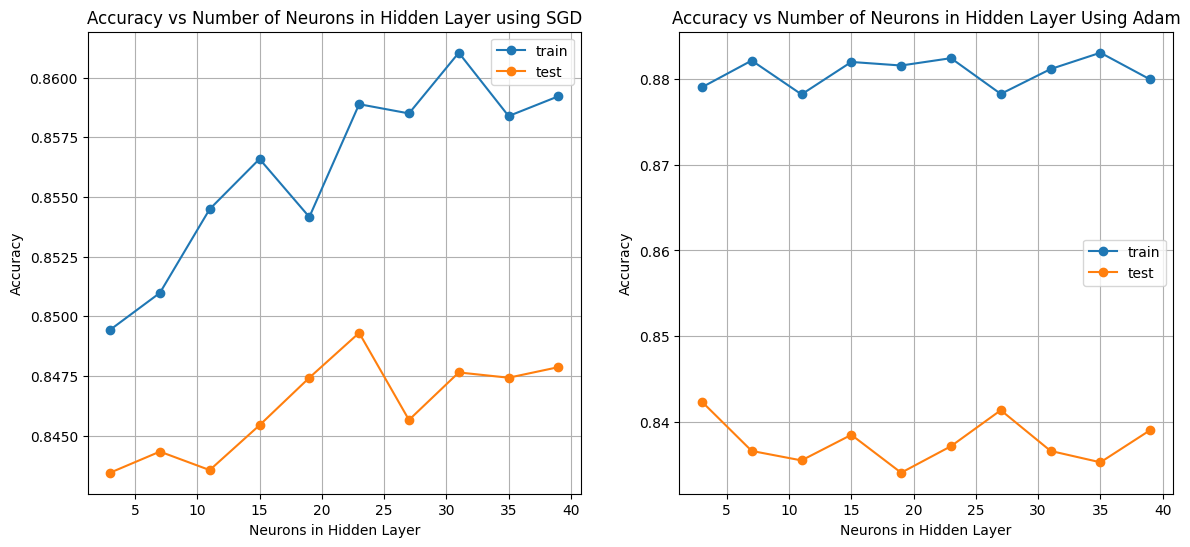

In [17]:
fig, axs = plt.subplots(1,2,figsize=(14,6))
axs[0].set_xlabel("Neurons in Hidden Layer")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Accuracy vs Number of Neurons in Hidden Layer using SGD")
axs[0].plot(neurons_list_SGD, nn_1_training_accuracy_SGD, marker="o", label="train")
axs[0].plot(neurons_list_SGD, nn_1_test_accuracy_SGD, marker="o", label="test")
axs[0].grid('True')
axs[0].legend()

axs[1].set_xlabel("Neurons in Hidden Layer")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Accuracy vs Number of Neurons in Hidden Layer Using Adam")
axs[1].plot(neurons_list_ADAM, nn_2_training_accuracy_ADAM, marker="o", label="train")
axs[1].plot(neurons_list_ADAM, nn_2_test_accuracy_ADAM, marker="o", label="test")
axs[1].grid('True')
axs[1].legend()

### Varying training set size

Set up data sets with differing ratios of training and test data

In [18]:
trainData_1, testData_1, trainLabel_1, testLabel_1 = train_test_split(X_scaled,y,test_size=0.1)
trainData_2, testData_2, trainLabel_2, testLabel_2 = train_test_split(X_scaled,y,test_size=0.2)
trainData_3, testData_3, trainLabel_3, testLabel_3 = train_test_split(X_scaled,y,test_size=0.3)
trainData_4, testData_4, trainLabel_4, testLabel_4 = train_test_split(X_scaled,y,test_size=0.4)
trainData_5, testData_5, trainLabel_5, testLabel_5 = train_test_split(X_scaled,y,test_size=0.5)

test_size = [50,60,70,80,90]
test_size_training_accuracy = []
test_size_test_accuracy = []

nn_3 = MLPClassifier(hidden_layer_sizes=(9), max_iter=1000, alpha=1e-4,solver='sgd', learning_rate_init=.001)
nn_3.fit(trainData_5,trainLabel_5)
test_size_training_accuracy.append(nn_3.score(trainData_5,trainLabel_5))
test_size_test_accuracy.append(nn_3.score(testData_5,testLabel_5))
nn_4 = MLPClassifier(hidden_layer_sizes=(9), max_iter=1000, alpha=1e-4,solver='sgd', learning_rate_init=.001)
nn_4.fit(trainData_4,trainLabel_4)
test_size_training_accuracy.append(nn_4.score(trainData_4,trainLabel_4))
test_size_test_accuracy.append(nn_4.score(testData_4,testLabel_4))
nn_5 = MLPClassifier(hidden_layer_sizes=(9), max_iter=1000, alpha=1e-4,solver='sgd', learning_rate_init=.001)
nn_5.fit(trainData_3,trainLabel_3)
test_size_training_accuracy.append(nn_5.score(trainData_3,trainLabel_3))
test_size_test_accuracy.append(nn_5.score(testData_3,testLabel_3))
nn_6 = MLPClassifier(hidden_layer_sizes=(9), max_iter=1000, alpha=1e-4,solver='sgd', learning_rate_init=.001)
nn_6.fit(trainData_2,trainLabel_2)
test_size_training_accuracy.append(nn_6.score(trainData_2,trainLabel_2))
test_size_test_accuracy.append(nn_6.score(testData_2,testLabel_2))
nn_7 = MLPClassifier(hidden_layer_sizes=(9), max_iter=1000, alpha=1e-4,solver='sgd', learning_rate_init=.001)
nn_7.fit(trainData_1,trainLabel_1)
test_size_training_accuracy.append(nn_7.score(trainData_1,trainLabel_1))
test_size_test_accuracy.append(nn_7.score(testData_1,testLabel_1))

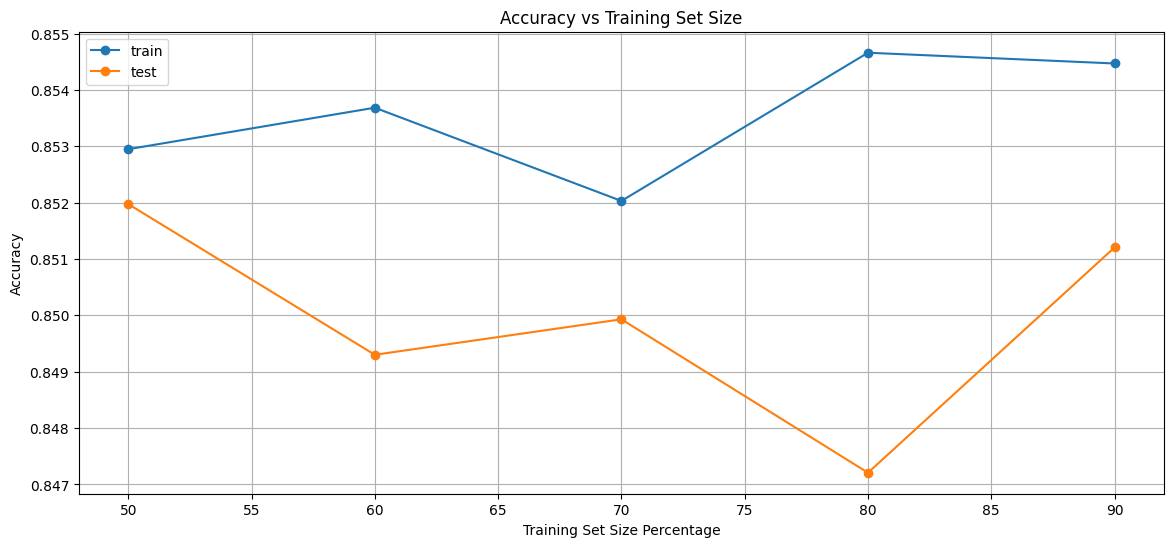

In [19]:
fig, ax = plt.subplots(figsize=(14,6))
ax.set_xlabel("Training Set Size Percentage")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs Training Set Size")
ax.plot(test_size, test_size_training_accuracy, marker="o", label="train")
ax.plot(test_size, test_size_test_accuracy, marker="o", label="test")
ax.grid('True')
ax.legend()

### L2 Regularization Tests

In [20]:
alpha = 0.0001
alpha_list = [0.0001, 0.001, 0.01, 0.1, 1.0]
nn_8_training_accuracy = []
nn_8_test_accuracy = []
for i in range(5):
    nn_8 = MLPClassifier(hidden_layer_sizes=9, max_iter=1000, alpha=alpha, solver='sgd', learning_rate_init=.001)
    nn_8.fit(trainData,trainLabel)
    nn_8_training_accuracy.append(nn_8.score(trainData,trainLabel))
    nn_8_test_accuracy.append(nn_8.score(testData,testLabel))
    alpha *= 10

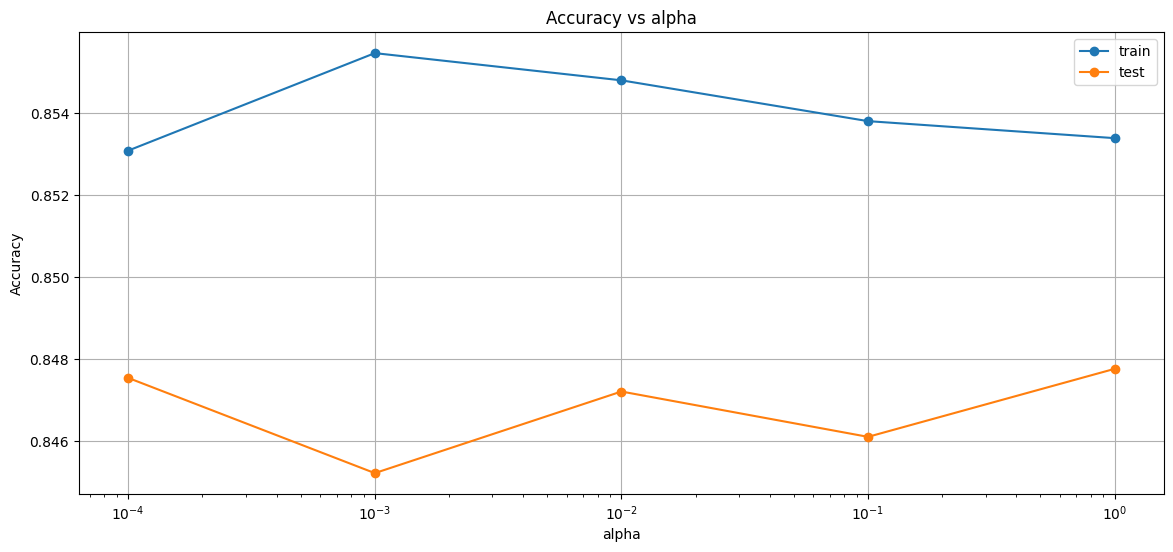

In [21]:
fig, ax = plt.subplots(figsize=(14,6))
ax.set_xscale('log')
ax.set_xlabel("alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs alpha")
ax.plot(alpha_list, nn_8_training_accuracy, marker='o',label="train")
ax.plot(alpha_list, nn_8_test_accuracy, marker='o', label="test")
ax.grid('True')
ax.legend()

In [32]:
alpha = 0.0001
layers = [50,50,50,50,50]
nn_9_training_accuracy = []
nn_9_test_accuracy = []
for i in range(5):
    nn_9 = MLPClassifier(hidden_layer_sizes=layers, max_iter=1000, alpha=alpha, solver='sgd', learning_rate_init=.001)
    nn_9.fit(trainData,trainLabel)
    nn_9_training_accuracy.append(nn_9.score(trainData,trainLabel))
    nn_9_test_accuracy.append(nn_9.score(testData,testLabel))
    alpha *= 10

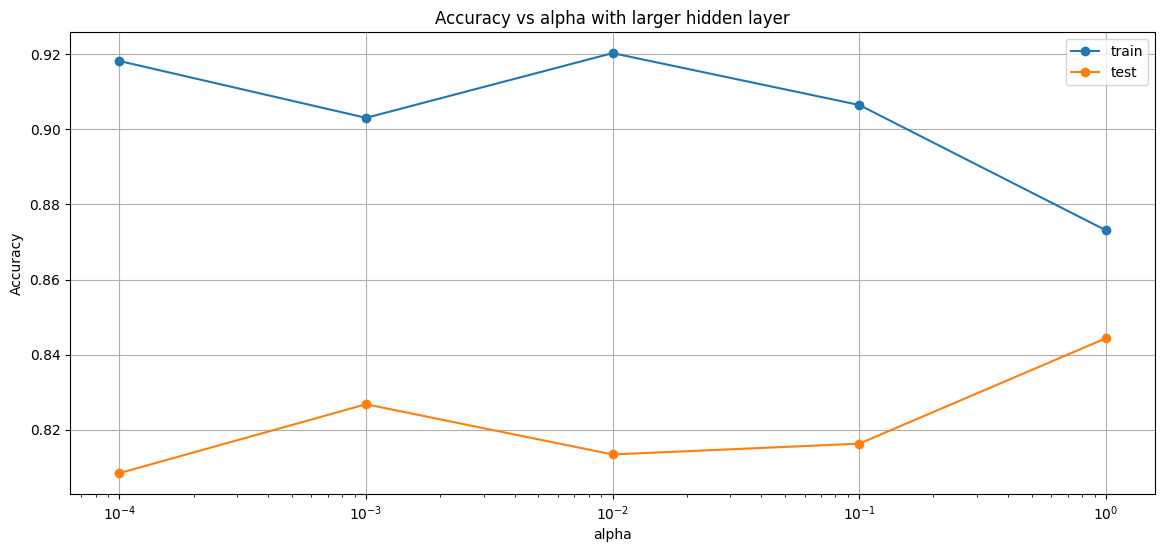

In [34]:
fig, ax = plt.subplots(figsize=(14,6))
ax.set_xscale('log')
ax.set_xlabel("alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs alpha with larger hidden layer")
ax.plot(alpha_list, nn_9_training_accuracy, marker='o',label="train")
ax.plot(alpha_list, nn_9_test_accuracy, marker='o', label="test")
ax.grid('True')
ax.legend()